In [40]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.models import resnet50, vgg16, VGG16_Weights, ResNet50_Weights


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [42]:
train_data_dir = 'C:/Users/trand/CS 184A/final_project/MRI Alzhemier/AugmentedAlzheimerDataset'

#we can use this dir to for validation and testing 
test_data_dir = 'C:/Users/trand/CS 184A/final_project/MRI Alzhemier/OriginalDataset'
classes = ['MildDemented', 'ModeratedDemented', 'NonDemented', 'VeryMildDemented']


In [43]:
transform_train = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    
}

#no flipping and rotation on dir because we want to test the raw truth - not train anymore 
transform_testval = {
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
}

In [44]:
train_dataset = datasets.ImageFolder(os.path.join(train_data_dir), transform=transform_train['train'])
test_dataset = datasets.ImageFolder(os.path.join(test_data_dir), transform=transform_testval['test'])

#we gonna split 50%-50% for test and validation
test_size = int(0.5 * len(test_dataset))
val_size = len(test_dataset) - test_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

#print(test_size, val_size)

In [45]:
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

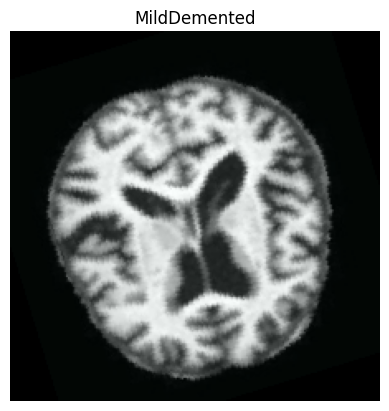

Saved image 1 to C:/Users/trand/CS 184A/saved_images


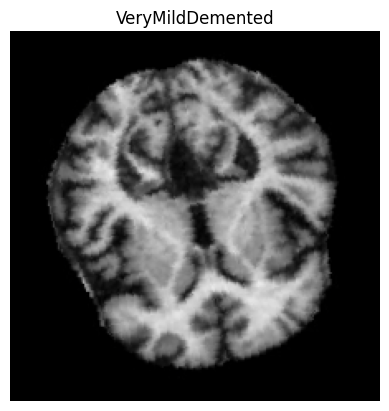

Saved image 2 to C:/Users/trand/CS 184A/saved_images


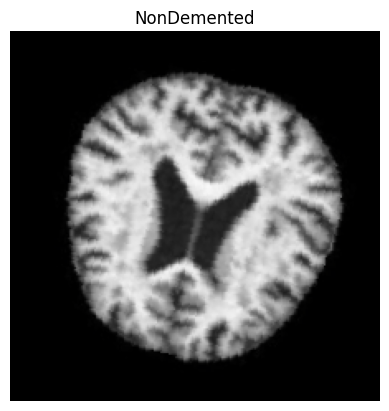

Saved image 3 to C:/Users/trand/CS 184A/saved_images


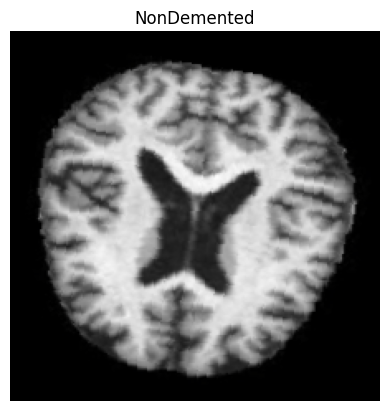

Saved image 4 to C:/Users/trand/CS 184A/saved_images


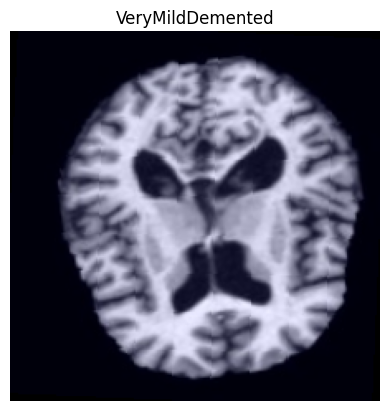

Saved image 5 to C:/Users/trand/CS 184A/saved_images


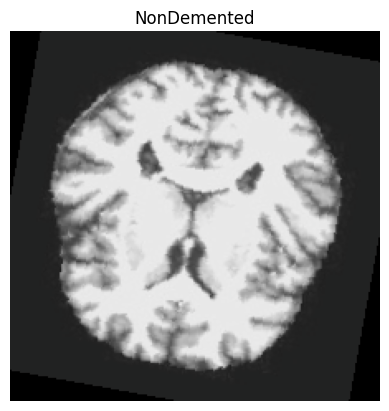

Saved image 6 to C:/Users/trand/CS 184A/saved_images


In [48]:
# Display some training images 
def imshow(images, labels, classes, save_path, img_name):
    # Undo normalization for display purposes
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(classes[labels])
    plt.savefig(os.path.join(save_path, img_name), bbox_inches='tight', pad_inches=0)
    plt.axis('off')
    plt.show()

# Get a batch of training data
save_directory = "C:/Users/trand/CS 184A/saved_images"
os.makedirs(save_directory, exist_ok=True)
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot the first few images in the batch
for i in range(6):  # Save 6 images
    img_name = f"training_image_{i + 1}.png"
    imshow(images[i], labels[i].item(), classes, save_directory, img_name)
    print(f"Saved image {i + 1} to {save_directory}")


In [7]:
#utilzie pretrain cnn architecture

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(classes)),  # 4 classes
    nn.LogSoftmax(dim=1)
)


In [8]:
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(vgg16.classifier[6].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(classes)),  # 4 classes
    nn.LogSoftmax(dim=1)
)


In [9]:
resnet = resnet.to(device)
vgg16 = vgg16.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)  # Use `vgg16.parameters()` for VGG16
steplr=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)


In [11]:
import torch
from tqdm import tqdm

# Define train_batch function
def train_batch(batch, model, optimizer, loss_fn, device):
    data, label = batch
    model.train()
    optimizer.zero_grad()
    pred = model(data.to(device))
    loss = loss_fn(pred, label.to(device))
    acc = (torch.max(pred, 1)[1] == label.to(device)).float().mean()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

# Define valid_batch function
@torch.no_grad()
def valid_batch(batch, model, loss_fn, device):
    data, label = batch
    model.eval()
    pred = model(data.to(device))
    loss = loss_fn(pred, label.to(device))
    acc = (torch.max(pred, 1)[1] == label.to(device)).float().mean()
    return loss.item(), acc.item()



In [12]:
# Training function with early stopping and model saving
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    device,
    n_epoch=30,
    patience=3,
    save_path="best_model_resnet.pth",
    scheduler=None
):
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses_all = []
    val_losses_all = []
    train_accs_all = []
    val_accs_all = []


    for epoch in range(n_epoch):
        # Training phase
        train_losses, train_accs = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epoch} Training"):
            loss, acc = train_batch(batch, model, optimizer, loss_fn, device)
            train_losses.append(loss)
            train_accs.append(acc)

        # Validation phase
        val_losses, val_accs = [], []
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epoch} Validating"):
            loss, acc = valid_batch(batch, model, loss_fn, device)
            val_losses.append(loss)
            val_accs.append(acc)

        # Compute averages
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_acc = sum(val_accs) / len(val_accs)


        train_losses_all.append(avg_train_loss)
        val_losses_all.append(avg_val_loss)
        train_accs_all.append(avg_train_acc)
        val_accs_all.append(avg_val_acc)

        print(
            f"Epoch {epoch+1}/{n_epoch} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

        # Early stopping
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved. Saving model to {save_path}...")
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Step scheduler if provided
        if scheduler:
            scheduler.step()

    print("Training complete.")

    return train_losses_all, val_losses_all, train_accs_all, val_accs_all


In [13]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model=resnet,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    n_epoch=30,
    patience=5,
    save_path="best_model.pth",
    scheduler=steplr
)




Epoch 1/30 Validating: 100%|██████████| 100/100 [00:37<00:00,  2.63it/s]


Epoch 1/30 - Train Loss: 0.6110, Train Acc: 0.7226, Val Loss: 0.3629, Val Acc: 0.8588
Validation loss improved. Saving model to best_model.pth...


Epoch 2/30 Validating: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Epoch 2/30 - Train Loss: 0.1935, Train Acc: 0.9261, Val Loss: 0.0765, Val Acc: 0.9709
Validation loss improved. Saving model to best_model.pth...


Epoch 3/30 Validating: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Epoch 3/30 - Train Loss: 0.0915, Train Acc: 0.9677, Val Loss: 0.0440, Val Acc: 0.9853
Validation loss improved. Saving model to best_model.pth...


Epoch 4/30 Validating: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 4/30 - Train Loss: 0.0605, Train Acc: 0.9790, Val Loss: 0.0364, Val Acc: 0.9872
Validation loss improved. Saving model to best_model.pth...


Epoch 5/30 Validating: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


Epoch 5/30 - Train Loss: 0.0501, Train Acc: 0.9832, Val Loss: 0.0342, Val Acc: 0.9872
Validation loss improved. Saving model to best_model.pth...


Epoch 6/30 Validating: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 6/30 - Train Loss: 0.0389, Train Acc: 0.9873, Val Loss: 0.0375, Val Acc: 0.9878
Validation loss did not improve. Patience counter: 1/5


Epoch 7/30 Validating: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 7/30 - Train Loss: 0.0370, Train Acc: 0.9881, Val Loss: 0.0833, Val Acc: 0.9672
Validation loss did not improve. Patience counter: 2/5


Epoch 8/30 Validating: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 8/30 - Train Loss: 0.0306, Train Acc: 0.9900, Val Loss: 0.0557, Val Acc: 0.9778
Validation loss did not improve. Patience counter: 3/5


Epoch 9/30 Validating: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Epoch 9/30 - Train Loss: 0.0278, Train Acc: 0.9911, Val Loss: 0.0202, Val Acc: 0.9941
Validation loss improved. Saving model to best_model.pth...


Epoch 10/30 Validating: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 10/30 - Train Loss: 0.0250, Train Acc: 0.9918, Val Loss: 0.0109, Val Acc: 0.9962
Validation loss improved. Saving model to best_model.pth...


Epoch 11/30 Validating: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Epoch 11/30 - Train Loss: 0.0081, Train Acc: 0.9975, Val Loss: 0.0053, Val Acc: 0.9984
Validation loss improved. Saving model to best_model.pth...


Epoch 12/30 Validating: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 12/30 - Train Loss: 0.0038, Train Acc: 0.9988, Val Loss: 0.0020, Val Acc: 0.9991
Validation loss improved. Saving model to best_model.pth...


Epoch 13/30 Validating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Epoch 13/30 - Train Loss: 0.0023, Train Acc: 0.9994, Val Loss: 0.0009, Val Acc: 0.9997
Validation loss improved. Saving model to best_model.pth...


Epoch 14/30 Validating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Epoch 14/30 - Train Loss: 0.0025, Train Acc: 0.9992, Val Loss: 0.0008, Val Acc: 1.0000
Validation loss improved. Saving model to best_model.pth...


Epoch 15/30 Validating: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


Epoch 15/30 - Train Loss: 0.0020, Train Acc: 0.9995, Val Loss: 0.0004, Val Acc: 1.0000
Validation loss improved. Saving model to best_model.pth...


Epoch 16/30 Validating: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Epoch 16/30 - Train Loss: 0.0011, Train Acc: 0.9996, Val Loss: 0.0010, Val Acc: 0.9994
Validation loss did not improve. Patience counter: 1/5


Epoch 17/30 Validating: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 17/30 - Train Loss: 0.0018, Train Acc: 0.9996, Val Loss: 0.0005, Val Acc: 0.9997
Validation loss did not improve. Patience counter: 2/5


Epoch 18/30 Validating: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Epoch 18/30 - Train Loss: 0.0012, Train Acc: 0.9997, Val Loss: 0.0004, Val Acc: 0.9997
Validation loss did not improve. Patience counter: 3/5


Epoch 19/30 Validating: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


Epoch 19/30 - Train Loss: 0.0015, Train Acc: 0.9995, Val Loss: 0.0006, Val Acc: 0.9997
Validation loss did not improve. Patience counter: 4/5


Epoch 20/30 Validating: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]

Epoch 20/30 - Train Loss: 0.0010, Train Acc: 0.9996, Val Loss: 0.0012, Val Acc: 0.9997
Validation loss did not improve. Patience counter: 5/5
Early stopping triggered.
Training complete.


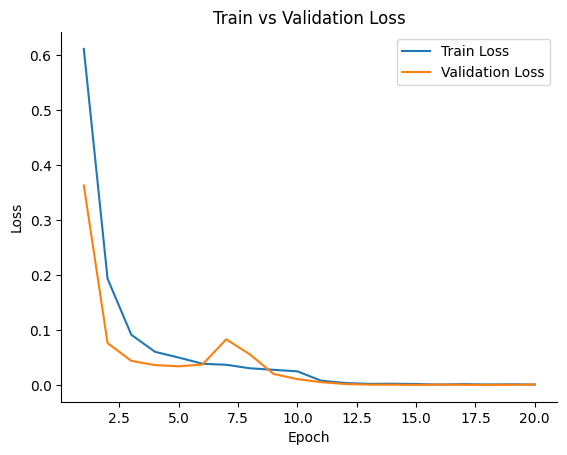

In [49]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()


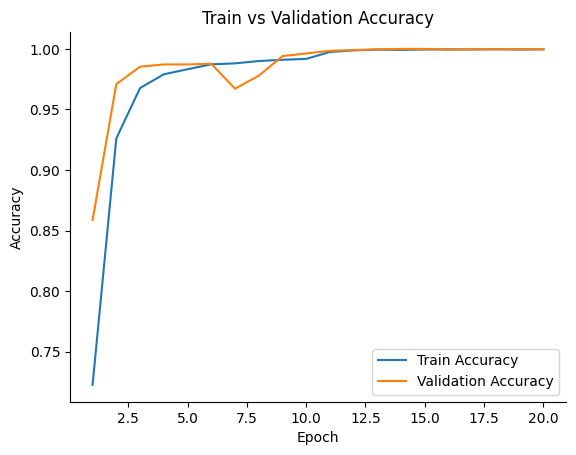

In [50]:
# Plot Train and Validation Accuracy
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# evaluate resnet 

#load the model
resnet.load_state_dict(torch.load("./best_model_resenet.pth"))
resnet.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the test dataset - similar to eval functions
@torch.no_grad()
def evaluate_model(model, test_loader, device):
    total = 0
    correct = 0
    all_preds = []
    all_labels = []

    for data, labels in tqdm(test_loader, desc="Testing"):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return all_preds, all_labels

# Get predictions and labels
predictions, true_labels = evaluate_model(resnet, test_loader, device)


Testing: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]

Test Accuracy: 0.9441


In [61]:
print(len(predictions), len(true_labels))

3200 3200


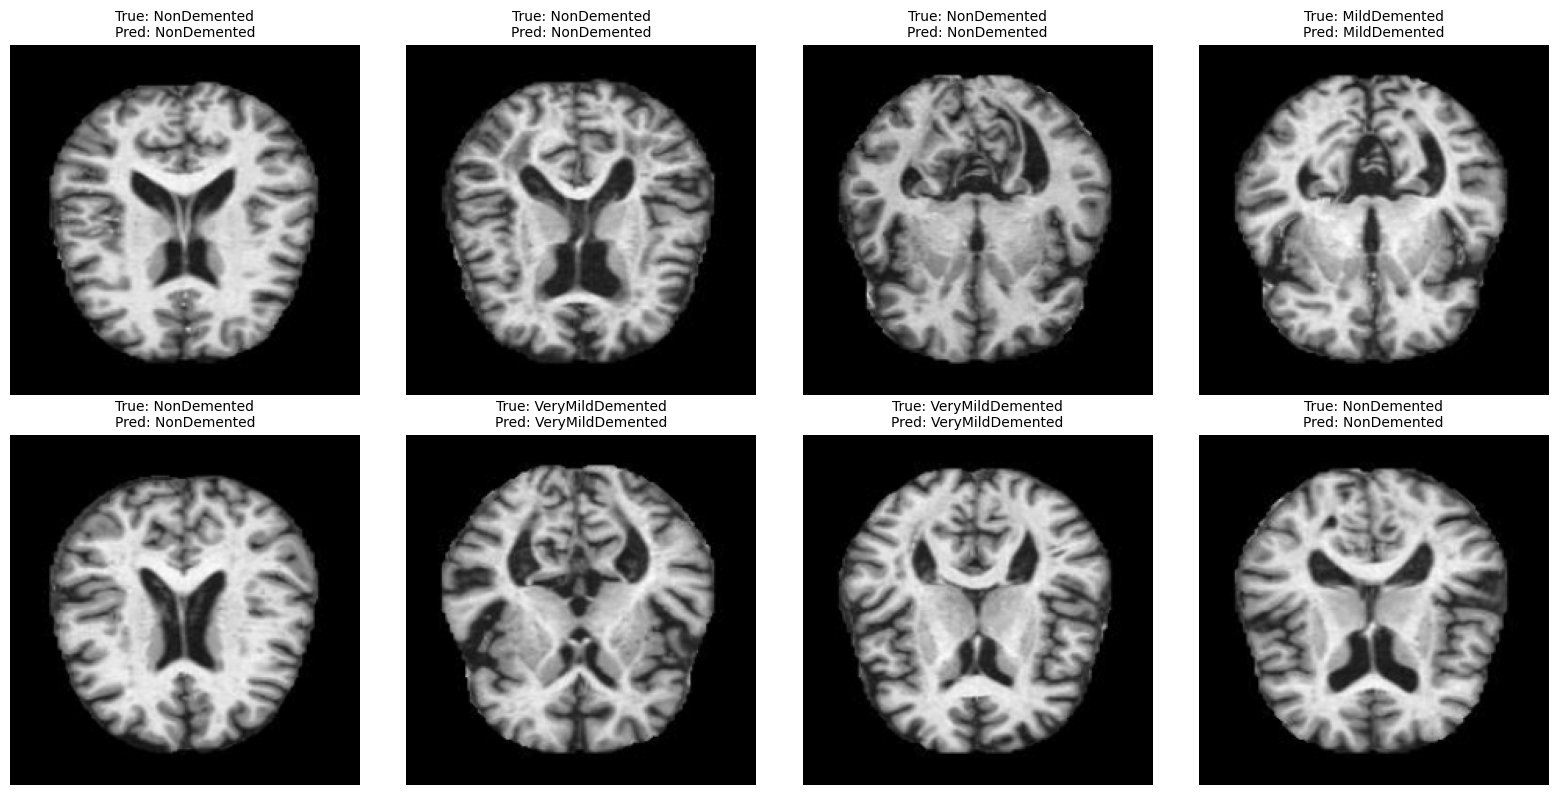

In [53]:
import random
# Visualize some test images with predicted and true labels
def display_predictions(test_loader, predictions, true_labels, classes):
        # Flatten all test data and labels for easy access
    all_data = []
    for data, _ in test_loader:
        all_data.append(data)
    all_data = torch.cat(all_data, dim=0)
    
    # Randomly select 8 indices
    num_images = 8
    random_indices = random.sample(range(len(all_data)), num_images)
    selected_images = all_data[random_indices]
    selected_preds = [predictions[i] for i in random_indices]
    selected_labels = [true_labels[i] for i in random_indices]
    
    # Unnormalize images for display
    images = selected_images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    # Plot the random images with true and predicted labels
    plt.figure(figsize=(16, 8))
    for idx in range(num_images):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(images[idx])
        plt.title(
            f"True: {classes[selected_labels[idx]]}\nPred: {classes[selected_preds[idx]]}",
            fontsize=10
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# Display predictions
display_predictions(test_loader, predictions, true_labels, classes)

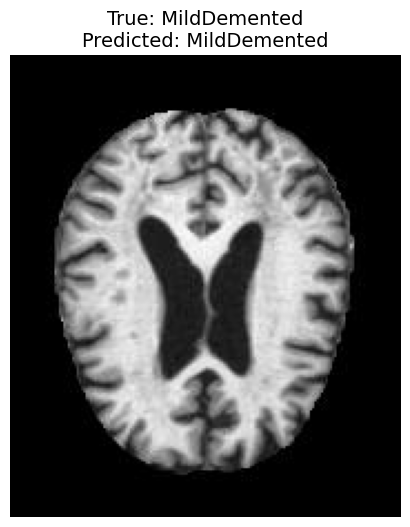

The predicted class for the image is: MildDemented


In [ ]:
# #predict a single input image

# from PIL import Image

# def predict_single_image(model, image_path, true_labels, transform, classes, device):
#     """
#     Predicts the class of a single image using the trained model.

#     Args:
#         model (torch.nn.Module): Trained model.
#         image_path (str): Path to the image.
#         transform (torchvision.transforms.Compose): Transformations to apply to the image.
#         classes (list): List of class names.
#         device (torch.device): Device to perform inference on.

#     Returns:
#         str: Predicted class label.
#     """
#     # Load the image
#     image = Image.open(image_path).convert("RGB")

#     # Apply transformations
#     input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

#     model.eval()

#     with torch.no_grad():
#         # Perform the forward pass
#         output = model(input_tensor)
#         _, predicted_idx = torch.max(output, 1)

#     # Map the predicted index to the class label
#     predicted_class = classes[predicted_idx.item()]

#     plt.figure(figsize=(6, 6))
#     plt.imshow(image)
#     plt.title(f"True: {true_labels}\nPredicted: {predicted_class}", fontsize=14)
#     plt.axis("off")
#     plt.show()

#     return predicted_class

# # Path to your image and the label
# image_path = "C:/Users/trand/CS 184A/final_project/MRI Alzhemier/OriginalDataset/MildDemented/26 (25).jpg"
# true_labels = "MildDemented"
# # Transformations (use the same as the test set)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Predict the class of the image
# predicted_class = predict_single_image(resnet, image_path, true_labels, transform, classes, device)

# print(f"The predicted class for the image is: {predicted_class}")


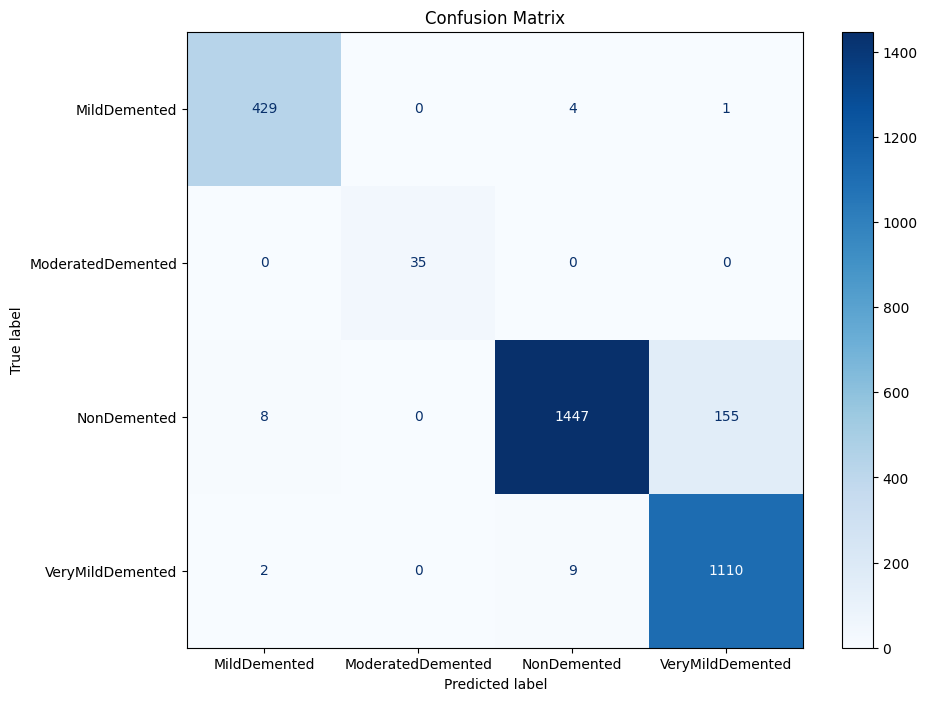

In [62]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)  # Compute the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

# Load the class names from your dataset
#class_names = test_dataset.classes  # Update this to match your dataset

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions, classes)


In [63]:
from sklearn.metrics import classification_report

# Generate a classification report
def print_classification_report(true_labels, predictions, class_names):
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))

# Load the class names from your dataset
print(len(true_labels))
print(len(predictions))
# Print the classification report
print_classification_report(true_labels, predictions, classes)


3200
3200
Classification Report:
                   precision    recall  f1-score   support

     MildDemented       0.98      0.99      0.98       434
ModeratedDemented       1.00      1.00      1.00        35
      NonDemented       0.99      0.90      0.94      1610
 VeryMildDemented       0.88      0.99      0.93      1121

         accuracy                           0.94      3200
        macro avg       0.96      0.97      0.96      3200
     weighted avg       0.95      0.94      0.94      3200



In [ ]:
# from tqdm import tqdm
# #import torch

# def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3, save_path="best_model.pth"):
#     model.train()
#     train_losses, val_losses = [], []
#     best_val_loss = float("inf")
#     patience_counter = 0

#     for epoch in range(epochs):
#         train_loss = 0
#         val_loss = 0
#         correct_train = 0
#         correct_val = 0

#         print(f"Epoch {epoch + 1}/{epochs}")
        
#         # Training loop with progress bar
#         model.train()
#         train_loop = tqdm(train_loader, desc="Training", leave=False)
#         for images, labels in train_loop:
#             images, labels = images.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             output = model(images)
#             loss = criterion(output, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()

#             # Calculate training accuracy
#             _, preds = torch.max(output, 1)
#             correct_train += torch.sum(preds == labels.data).item()

#             # Update progress bar
#             train_acc = correct_train / len(train_loader.dataset)
#             train_loop.set_postfix(loss=loss.item(), accuracy=train_acc)

#         # Validation loop with progress bar
#         model.eval()
#         val_loop = tqdm(val_loader, desc="Validating", leave=False)
#         with torch.no_grad():
#             for images, labels in val_loop:
#                 images, labels = images.to(device), labels.to(device)
#                 output = model(images)
#                 loss = criterion(output, labels)
#                 val_loss += loss.item()

#                 # Calculate validation accuracy
#                 _, preds = torch.max(output, 1)
#                 correct_val += torch.sum(preds == labels.data).item()

#                 # Update progress bar
#                 val_acc = correct_val / len(val_loader.dataset)
#                 val_loop.set_postfix(loss=loss.item(), accuracy=val_acc)

#         # Compute average losses and accuracies
#         train_loss /= len(train_loader)
#         val_loss /= len(val_loader)
#         train_acc = correct_train / len(train_loader.dataset)
#         val_acc = correct_val / len(val_loader.dataset)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

#         # Early Stopping Check
#         if val_loss < best_val_loss:
#             print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), save_path)  # Save the model
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

#         if patience_counter >= patience:
#             print("Early stopping triggered. Stopping training.")
#             break

#     return train_losses, val_losses



In [17]:
# train_losses, val_losses = train_model(resnet, train_loader, val_loader, criterion, optimizer, epochs=10)
